In [1]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from adjustText import adjust_text
import plotly.express as px
import sqlite3 as sql

## Retreive Data from Database

In [2]:
# path to current SQLite  db
path = "data.sqlite"

# establish connection
conn = sql.connect(path)
cur = conn.cursor()

# read relevant (see below) columns from the dna table into a new database.
# close connection

db = pd.read_sql_query(
    "SELECT accession_number, name, category, mt_dna, length FROM MtDNA",
    conn
)

conn.close()

db

,accession_number,name,category,mt_dna,length
0,NC_011137,European Neanderthal,Human,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,16565
1,KC345764,South African Human,Human,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,16567
2,FN673705,Altai Denisovan,Human,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,16570
3,NC_002083,Sumatran Orangutan,Orangutan,GTTTATGTAGCTTATTCTATCCAAAGCAATGCACTGAAAATGTCTC...,16499
4,NC_001646,Bornean Orangutan,Orangutan,GTTTATGTAGCTTATTCCATCCAAAGCAATACACTGAAAATGTCTC...,16389
5,NC_011120,Western Lowland Gorilla,Gorilla,GTTTATGTAGCTTACCTCCCCAAAGCAATACACTGAAAATGTTTCG...,16412
6,KM242275,Eastern Lowland Gorilla,Gorilla,GTTTATGTAGCTTACCTCCCCAAAGCAATACACTGAAAATGTTTCG...,16416
7,NC_001644,Bonobo,Chimp,GTTTATGTAGCTTACCCCCTTAAAGCAATACACTGAAAATGTTTCG...,16563
8,JF727201,Chimp Schweinfurthii,Chimp,GTTTATGTAGCTTACCCCCTCAAAGCAATACACTGAAAATGTTTCG...,16560
9,KM679417,Chimp Ellioti,Chimp,GTTTATGTAGCTTACCCCCTCAAAGCAATACACTGAAAATGTTTCG...,16559


## Building Feature Matrix based on given k

In [10]:
def build_feet_matrix(db, k = 3):
    """
    input: mtdna db (pandas.DataFrame), k (int, default =3)

    contruct kmer frequency matrix from the mtdna sequences

    returns numpy.ndarray, a matrix such that each row is the kmer frequency
    vector for some sequence.
    """

    # initialize vectors, convert each sequence into its kmer vector
    vectors = []
    for seq in db["mt_dna"]:
        vec = get_kmers(seq, k)
        vectors.append(vec)

    # stack the vectors to create the desired matrix
    x = np.vstack(vectors)
    return x

def get_kmers(sequence, k = 3):
    """
    input: a sequence (str), desired k (int)

    computes kmer frequency counts for a single mtdna sequence

    returns numpy.ndarray of kmer counts
    """

    # generate all possible kmers of given length k from alphabet ACGT
    kmers = [''.join(p) for p in product("ACGT", repeat = k)]
    counts = {kmer: 0 for kmer in kmers}

    # initialize count to 0, "slide" accross the entire sequence and count kmers
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i: i + k]
        if kmer in counts:
            counts[kmer] += 1

    # return the counts in kmer order
    return np.array([counts[k] for k in kmers])

## 2D PCA

In [11]:
def plot_2D_PCA(X, db, n_clusters = 5, title = "PCA Plot"):
    """
    input: feature matrix X (numpy.ndarray), db (pandas.DataFrame), n_clusters
    (int, default = 5), plot title: (str)

    Perform PCA on the feature matrix X. Plots PC1 and PC2. Labels both points
    and clusters.

    returns: none, displays a cool plot
    """

    # compute first two PC's
    pca = PCA(n_components = 2)
    pcs = pca.fit_transform(X)

    # clustering
    clustering = AgglomerativeClustering(n_clusters = n_clusters)
    cluster_labels = clustering.fit_predict(X)

    # Add PCA and cluster labels to the db
    db["cluster"] = cluster_labels
    db["PC1"] = pcs[:,0]
    db["PC2"] = pcs[:,1]

    # plot figure
    plt.figure(figsize = (10,8))
    colors = plt.cm.get_cmap("tab10", n_clusters)

    # each cluster will be its unique cluster. label each point. label clusters
    # with associated category name
    for clust in range(n_clusters):
        cluster_db = db[db["cluster"] == clust]
        plt.scatter(cluster_db["PC1"], cluster_db["PC2"],
                    color = colors(clust), label=", ".join(
                        cluster_db["category"].unique()))

        categories = cluster_db["category"].unique()
        category_text = ", ".join(categories)
        mean_x = cluster_db["PC1"].mean()
        mean_y = cluster_db["PC2"].min() - 7
        plt.text(mean_x, mean_y, category_text, fontsize = 10, ha= "center",
                 fontweight = "bold")

    texts = []
    for i, row in db.iterrows():
        texts.append(plt.text(row["PC1"], row["PC2"], row["name"], fontsize=8))

    # Adjust text to avoid overlaps
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend(title="Clusters")
    plt.show()

/tmp/ipython-input-2122201106.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_clusters)


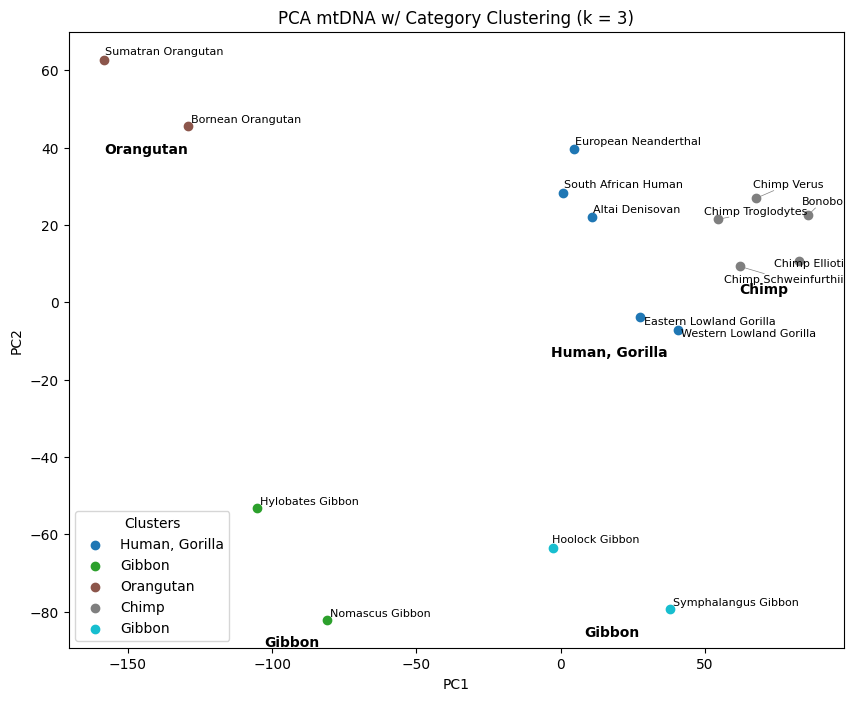

/tmp/ipython-input-2122201106.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_clusters)


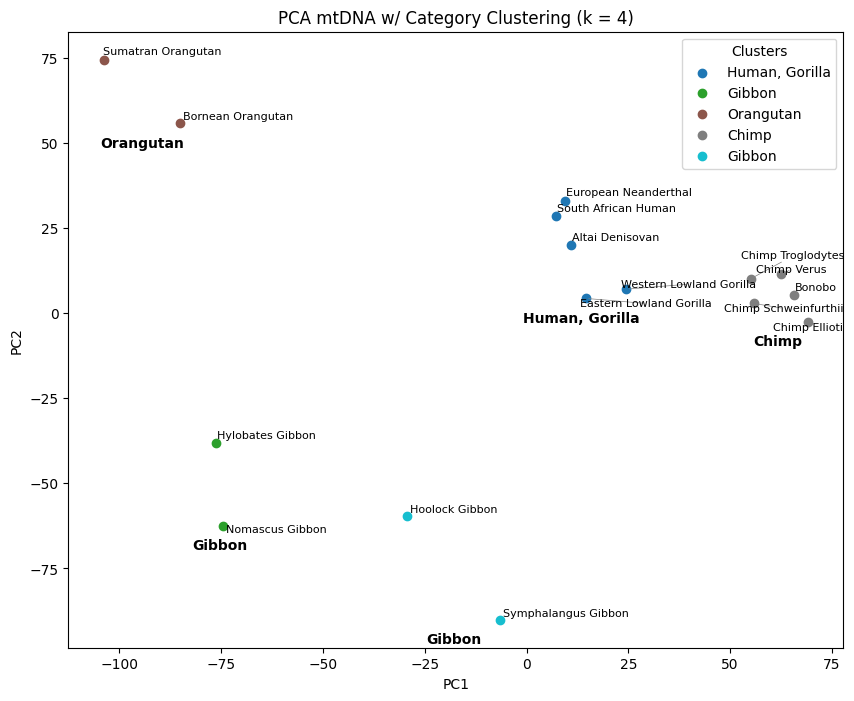

/tmp/ipython-input-2122201106.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_clusters)


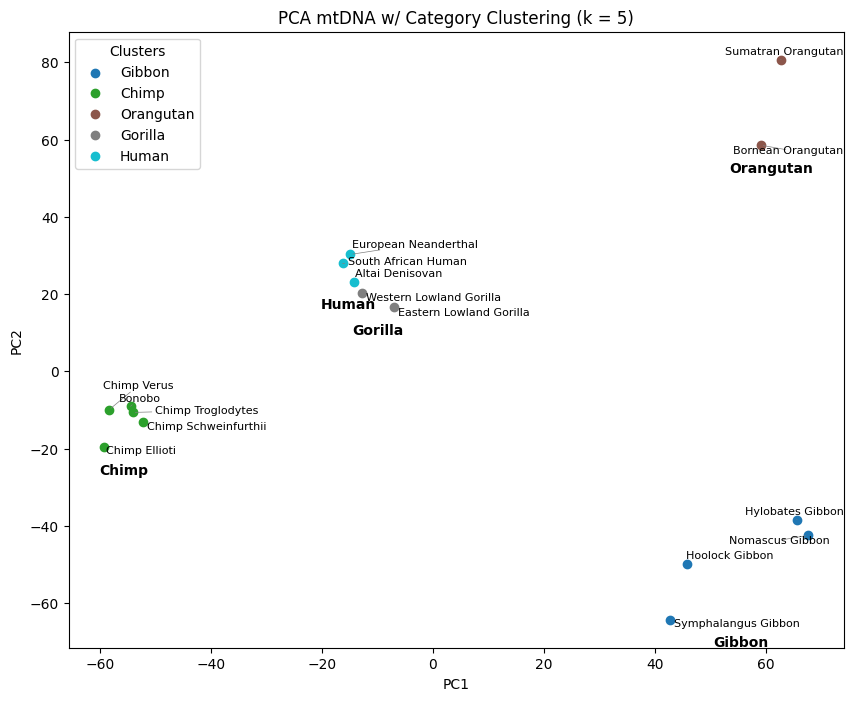

/tmp/ipython-input-2122201106.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_clusters)


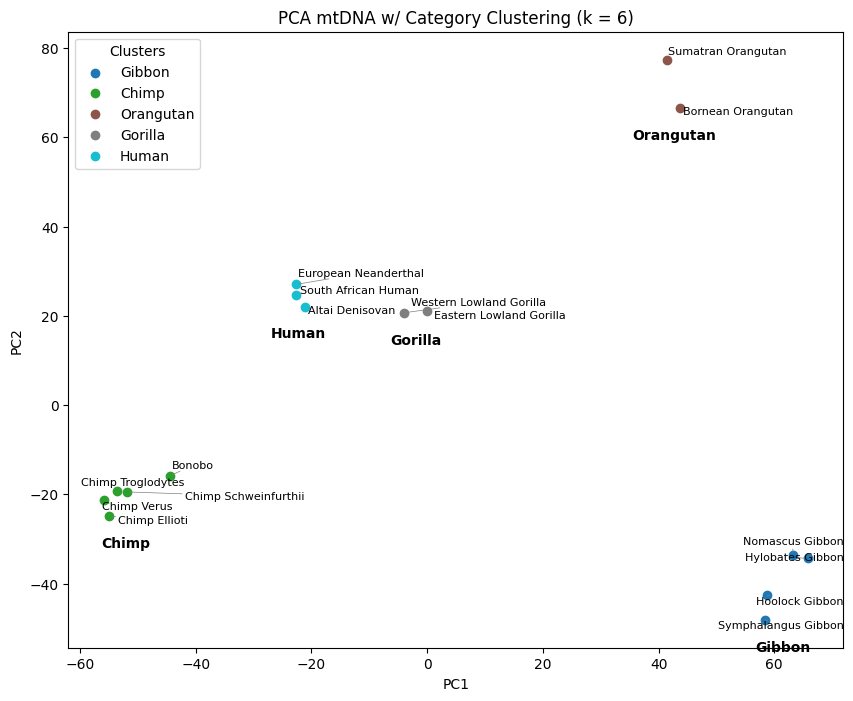

/tmp/ipython-input-2122201106.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_clusters)


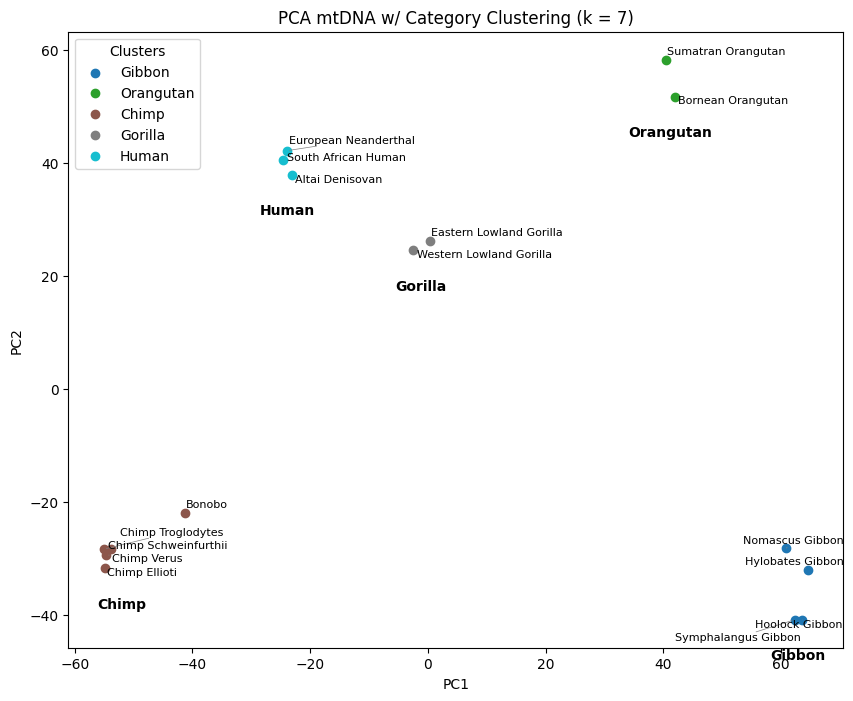

/tmp/ipython-input-2122201106.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_clusters)


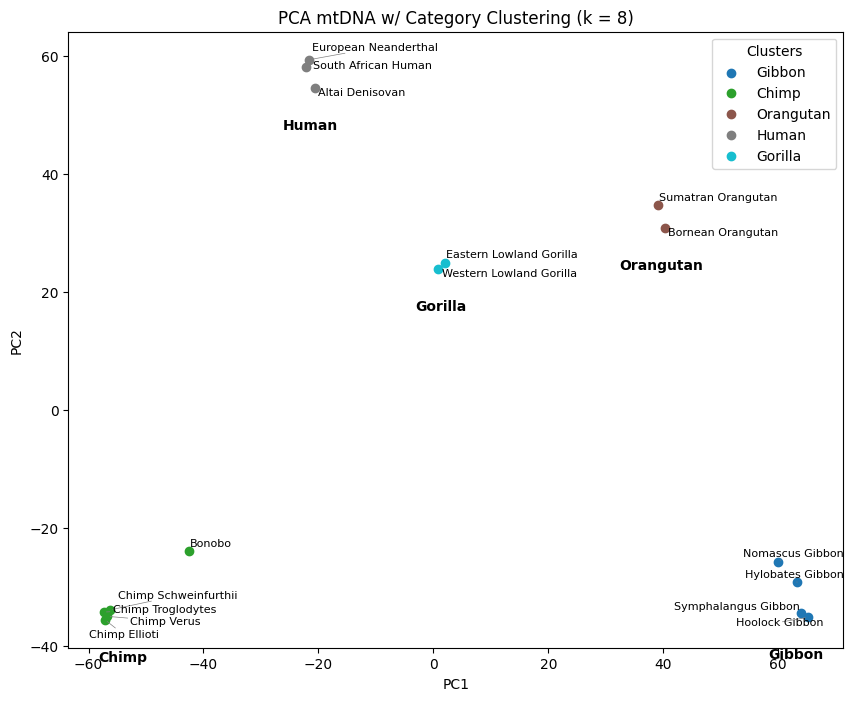

/tmp/ipython-input-2122201106.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_clusters)


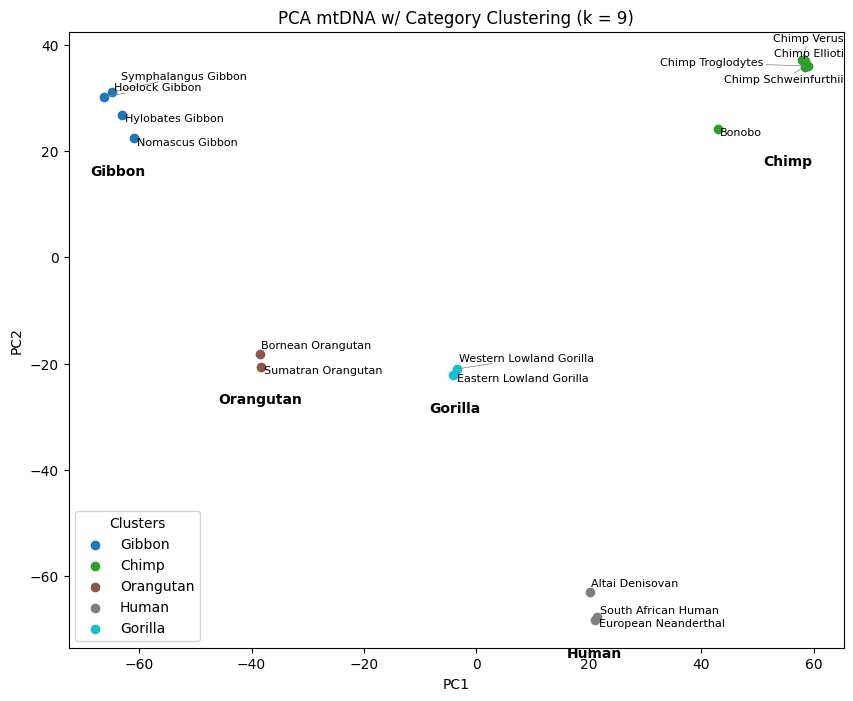

In [12]:
# feature matrix and PCA for k = 3 through 9

Xs = {}

for k in range(3, 10):
    Xs[k] = build_feet_matrix(db, k=k)

for k, X in Xs.items():
    plot_2D_PCA(X, db, n_clusters=5,
            title=f"PCA mtDNA w/ Category Clustering (k = {k})")

## PLOT BY CATEGORY

In [ ]:
def plot_2D_PCA_by_category(X, db, title="PCA Plot by Category"):
    """
    input: feature matrix X (numpy.ndarray), db (pandas.DataFrame)
    plot title: (str))

    Perform PCA on the feature matrix X. Plots PC1 and PC2. Only labels points,
    and colored by TRUE category.

    returns: none, displays plot
    """

    # compute PCA
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X)

    db["PC1"] = pcs[:,0]
    db["PC2"] = pcs[:,1]

    plt.figure(figsize=(10,8))

    # Get unique categories, assign colors
    unique_categories = db["category"].unique()
    colors = plt.cm.get_cmap("tab10", len(unique_categories))

    for i, category in enumerate(unique_categories):
        category_db = db[db["category"] == category]
        plt.scatter(category_db["PC1"], category_db["PC2"],
                    color=colors(i), label=category)

    texts = []
    for i, row in db.iterrows():
        texts.append(plt.text(row["PC1"], row["PC2"], row["name"], fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend(title="True Category")
    plt.show()


/tmp/ipython-input-908551724.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_categories))


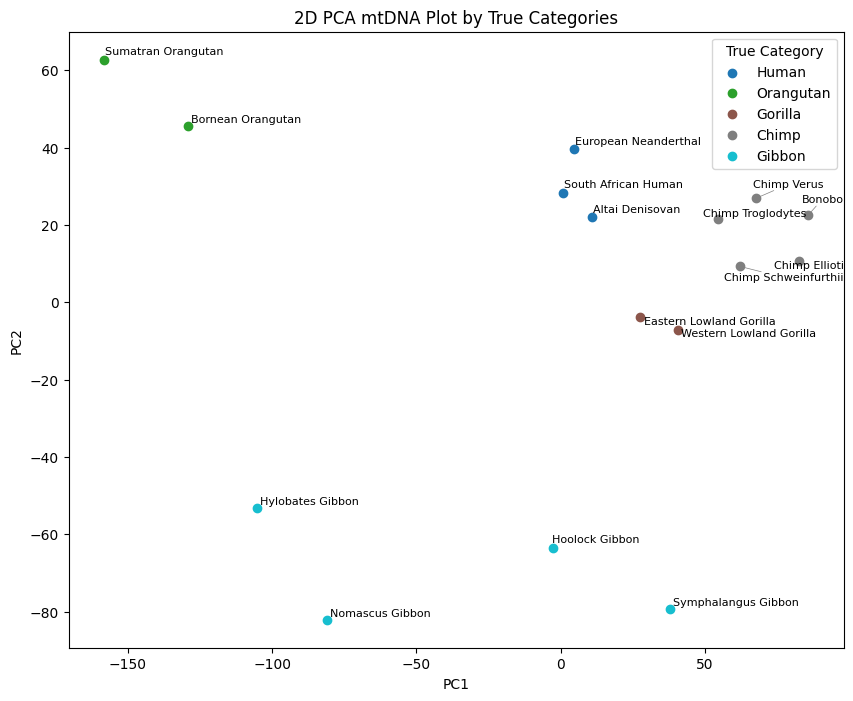

In [ ]:
X3 = build_feet_matrix(db, 3)

plot_2D_PCA_by_category(X3, db, "2D PCA mtDNA Plot by True Categories")

## 3D PCA via plotly

In [ ]:
def plot_3D_PCA(X, db, n_clusters=5, title="3D PCA Plot"):
    """
    input: feature matrix X (numpy.ndarray), db (pandas.DataFrame)
    plot title: (str))

    Perform PCA on the feature matrix X (Now with 3 components). Plots PC1 and
    PC2 and PC3 via plotly.

    returns: none, displays an interactable plot.
    """
    # Run PCA with 3 components
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)

    # Clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(X)

    # work on a copied db to avoid messing with original data
    db = db.copy()
    db["cluster"] = cluster_labels
    db["PC1"] = pcs[:, 0]
    db["PC2"] = pcs[:, 1]
    db["PC3"] = pcs[:, 2]

    # assign each cluster a readable group label for the legend
    db["cluster_category"] = db.groupby("cluster")["category"].transform(
        lambda x: ", ".join(x.unique()))

    # Generates the 3D PCA plot
    fig = px.scatter_3d(
        db,
        x="PC1",
        y="PC2",
        z="PC3",
        color="cluster_category",
        symbol="cluster_category",
        hover_name="name",
        hover_data={"category": True, "cluster": True},
        title=title
    )

    # label axes and legend
    fig.update_layout(
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3"
        ),
        legend_title="Clusters",
        margin=dict(l=0, r=0, b=0, t=50)
    )

    fig.show()

In [ ]:
X3 = build_feet_matrix(db, 3)
plot_3D_PCA(X3, db, n_clusters=5,title = "Mitochondrial DNA 3D PCA, k = 3, n_clusters = 5")

## 3d PCA by TRUE Category

In [ ]:
def plot_3D_PCA_by_category(X, db, title="3D PCA Plot by True Category"):
    """
    input: feature matrix X (numpy.ndarray), db (pandas.DataFrame)
    plot title: (str))

    Perform PCA on the feature matrix X (Now with 3 components). Plots PC1 and
    PC2 and PC3 via plotly. Points are colored by true category rather than
    cluster

    returns: none, displays an interactable plot.
    """
    # Run PCA with 3 components
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)

    # work on db copy
    db = db.copy()
    db["PC1"] = pcs[:, 0]
    db["PC2"] = pcs[:, 1]
    db["PC3"] = pcs[:, 2]

    # create 3D scatter plot with true category colors
    fig = px.scatter_3d(
        db,
        x="PC1",
        y="PC2",
        z="PC3",
        color="category",
        symbol="category",
        hover_name="name",
        hover_data={"category": True},
        title=title
    )

    # labeling axes and legend
    fig.update_layout(
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3"
        ),
        legend_title="True Category",
        margin=dict(l=0, r=0, b=0, t=50)
    )

    fig.show()


In [ ]:
plot_3D_PCA_by_category(X3, db,title = "3D PCA mtDNA Plot by True Categories")